In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/lawsdiv`


In [2]:
using DataFrames, DataFramesMeta, GLM, Chain
using Statistics, StatsBase, SpecialFunctions
using NFFT
using Plots, Measures

In [3]:
include("./Data_Input.jl")
using .DataImport

include("./Distributions.jl")
using .PlotDistributions

In [5]:
sep_data = DataImport.GetLongData("./Data/longitudinal.RData"; min_samples=1, min_counts=1, min_nreads=1e2);

 `sep_data` contains two hosts: `M3` and `F4`.\
 For each host there are four possible environments: `FECES`, `ORALCAVITY`, `L_PALM`, `R_PALM`.\
 Then each environment consists of a dataset stored in a dataFrame with the following features:\
 **project_id**: identifies projects\
**sample_id**: identifies samples (communities) gathered within the same environment\
**run_id**: identifies the machine run to identify species in a sample. Multiple runs are possible within the same sample\
**otu_id**: identifies species\
**count**: number of species with specific otu_id observed in a single run\
**nreads**: total number of species observed in a single run\
**experiment_day**: day passed from the beginning of data collection

In [6]:
first(sep_data["M3"]["ORALCAVITY"], 5)

Row,otu_id,count,project_id,sample_id,run_id,experiment_day,nreads
,Int32,Float64,String,String,String,Int32,Float64
1,5336,112.0,ERP021896,ERS1579465,ERR1868309,0,8698.0
2,10473,9.0,ERP021896,ERS1579465,ERR1868309,0,8698.0
3,10764,2.0,ERP021896,ERS1579465,ERR1868309,0,8698.0
4,21407,21.0,ERP021896,ERS1579465,ERR1868309,0,8698.0
5,24972,2.0,ERP021896,ERS1579465,ERR1868309,0,8698.0


# Distributions

In [24]:
AFDs = []
TAYLORs = []
MADs = []

for (key, sub_data) in sep_data
    for (subkey, data) in sub_data

        data.f = data.count ./ data.nreads # I can do this vecause there is only one sample with one run per day

        otus = unique(data.otu_id)
        max_day = maximum(data.experiment_day) + 1
        otu_groups = groupby(data, :otu_id)

        y = zeros(max_day, length(otus))
        env_data = []
        otu_index = Dict(otu => i for (i, otu) in enumerate(otus))

        for g in otu_groups
            otu = g.otu_id[1]
            i = otu_index[otu]
            for (t, fval) in zip(g.experiment_day, g.f)
                if 1 <= t+1 <= max_day
                    y[t+1, i] = fval
                end
            end

            y[:,i] .*= (count(!iszero, y[:,i]) / length(y[:,i])) # Multiply frequencies by occupancy
            push!(env_data, y[:,i])
        end

        global matrix_data = hcat(env_data...)
        
        afd = PlotDistributions.make_AFD(matrix_data; Δb=0.5, plot_fig=true, save_plot=false, plot_title="", data_label="$key $subkey", min_y_range=1e-6)
        push!(AFDs, afd)

        taylor = PlotDistributions.make_Taylor(matrix_data; Δb=0.5, plot_fig=true, save_plot=false, plot_title="", data_label="$key $subkey")
        push!(TAYLORs, taylor)

        mad = PlotDistributions.make_MAD(matrix_data; Δb=1.0, plot_fig=true, save_plot=false, plot_title="", data_label="$key $subkey")
        push!(MADs, mad)
    end
end

### AFD

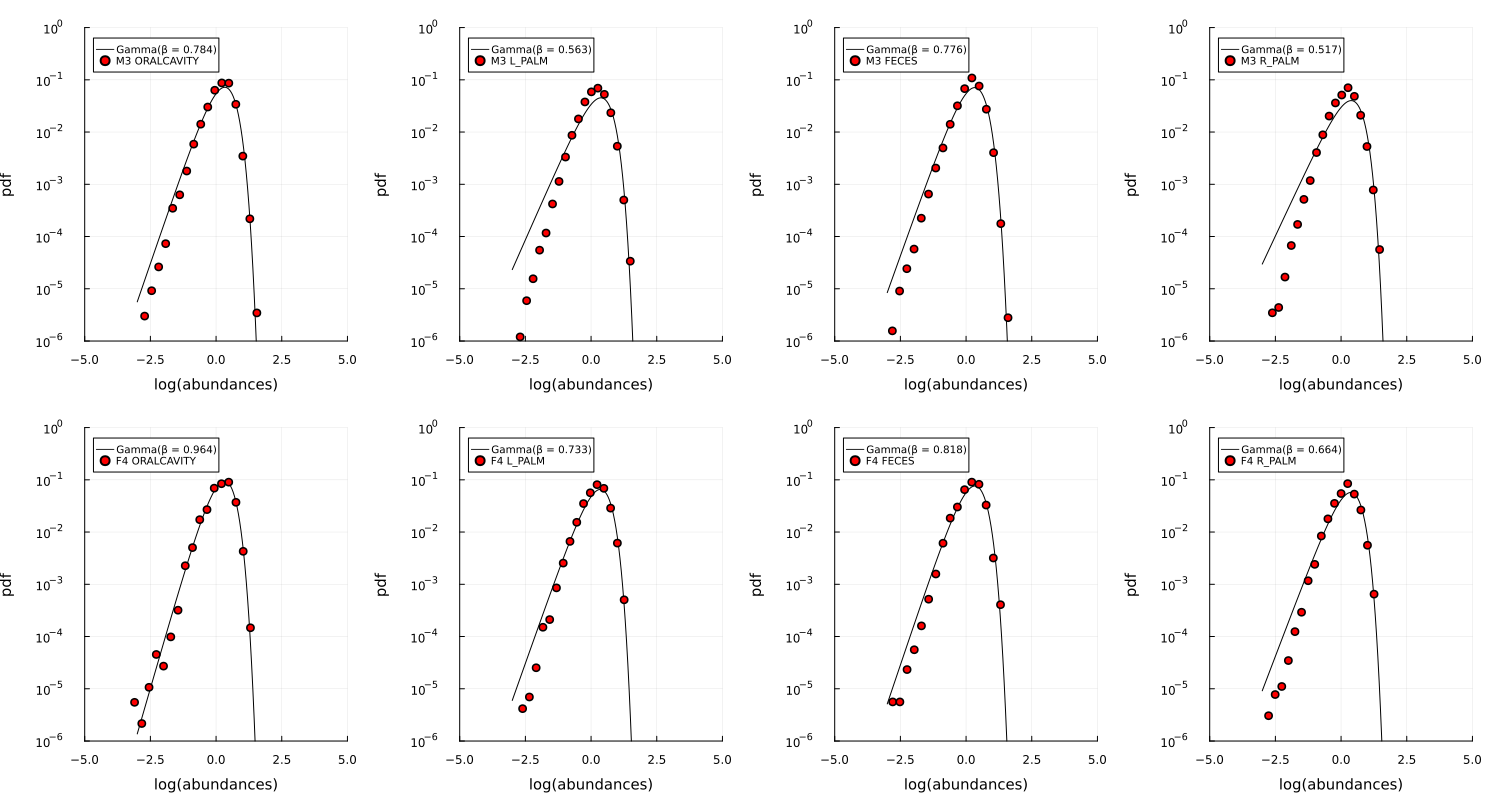

In [18]:
figs = [afd["fig"] for afd in AFDs]
combined_fig = plot(figs...;
    layout=(2, 4),
    size=(1500, 800),
    margin=5mm,  # or try 10mm
    guidefont=10,
    tickfont=8,
    legendfontsize=7,
)
display(combined_fig)

### Taylor

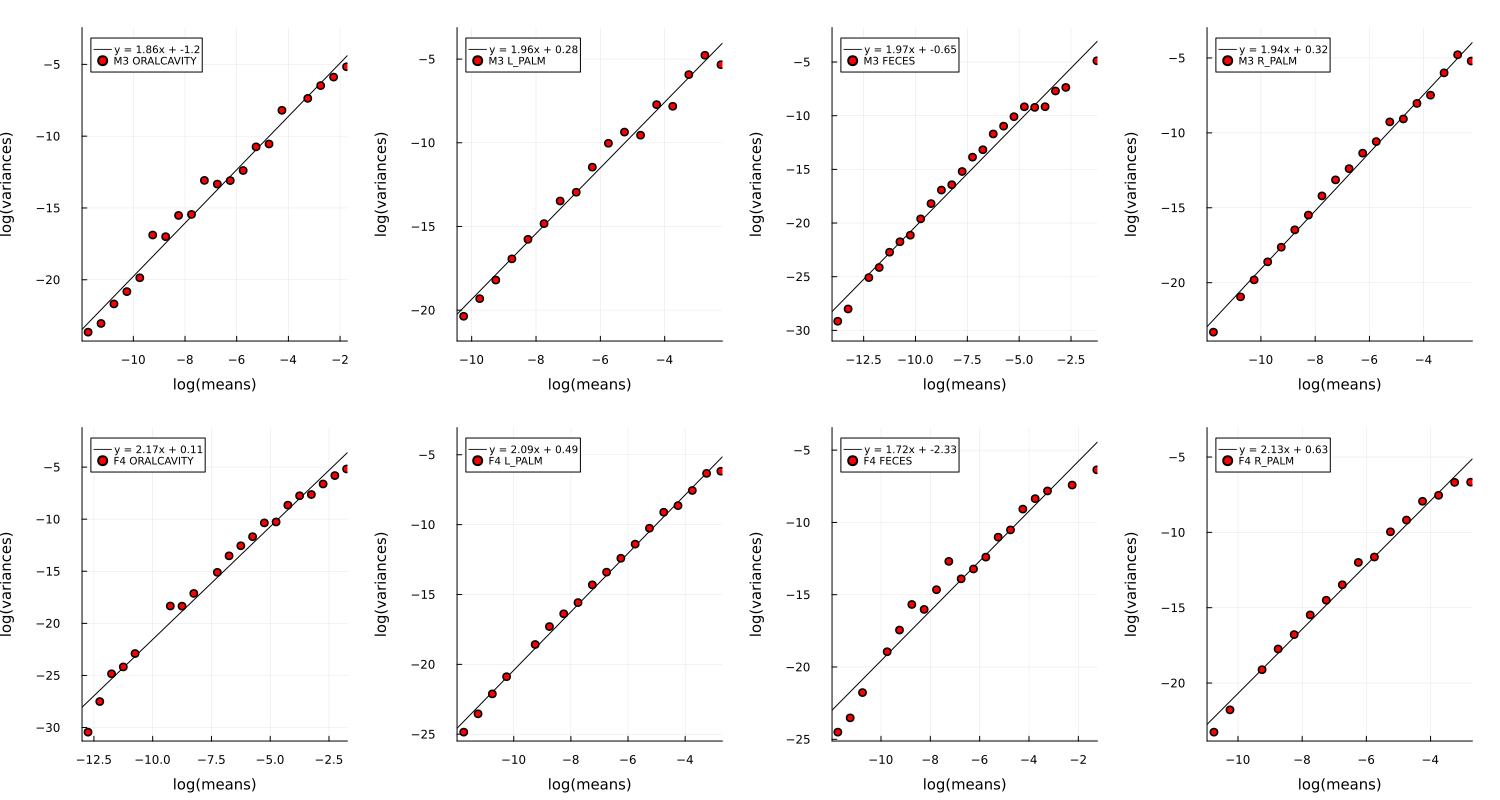

In [19]:
figs = [taylor["fig"] for taylor in TAYLORs]
combined_fig = plot(figs...;
    layout=(2, 4),
    size=(1500, 800),
    margin=5mm,  # or try 10mm
    guidefont=10,
    tickfont=8,
    legendfontsize=7,
)
display(combined_fig)

### MAD

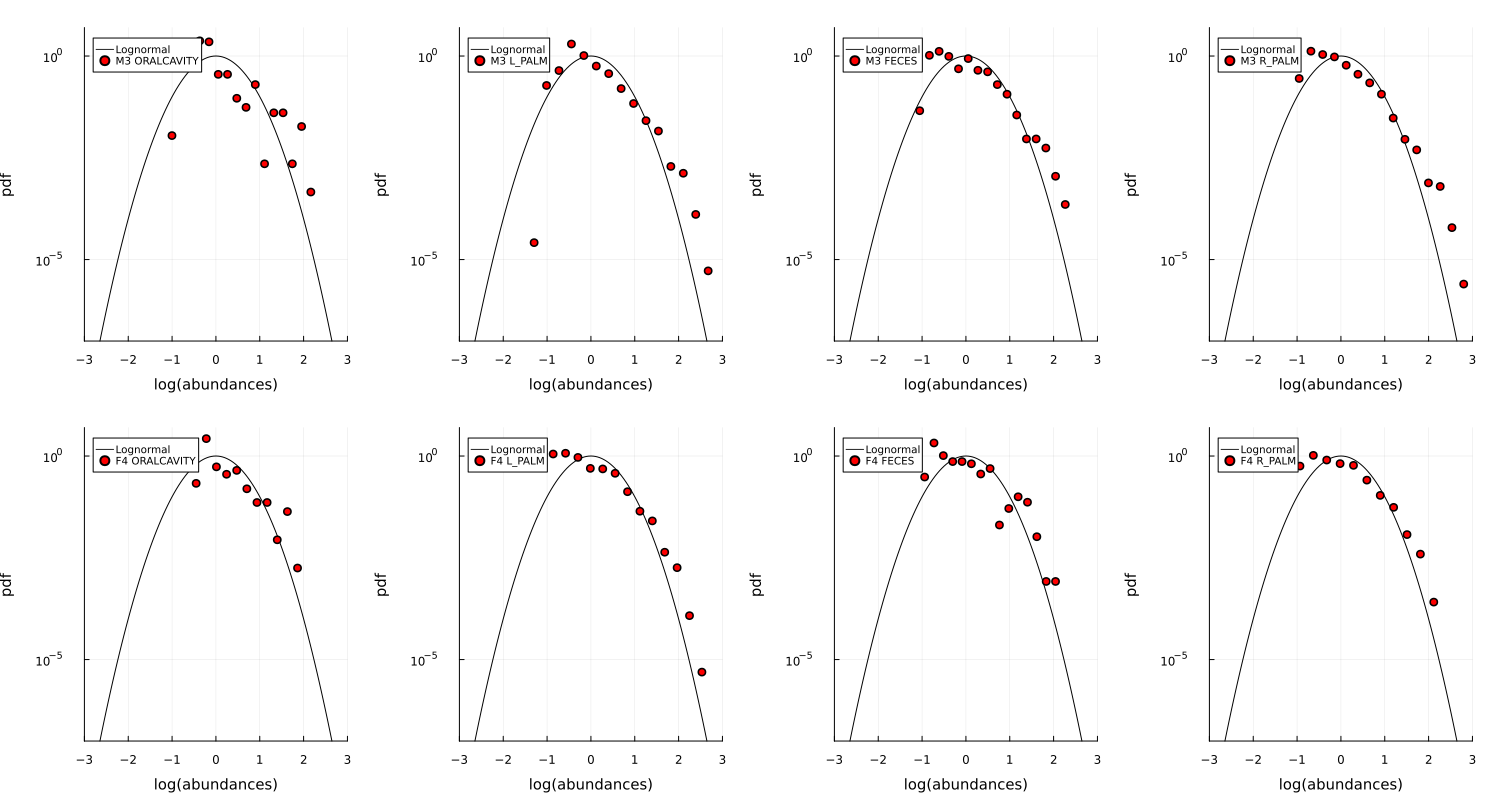

In [20]:
figs = [mad["fig"] for mad in MADs]
combined_fig = plot(figs...;
    layout=(2, 4),
    size=(1500, 800),
    margin=5mm,  # or try 10mm
    guidefont=10,
    tickfont=8,
    legendfontsize=7,
)
display(combined_fig)

### Correlations

In [34]:
using FHist

In [55]:
function compute_crosscor_matrix(X::AbstractMatrix, lags)
    S = size(X, 2)
    corrs = Matrix{Vector{Float64}}(undef, S, S)

    for i in 1:S, j in 1:S
        corrs[i, j] = crosscor(X[:, i], X[:, j], lags)
    end

    return corrs
end

lags = [0]
cross_corrs = compute_crosscor_matrix(matrix_data, lags)
flat_cross_corrs = vcat(cross_corrs...);

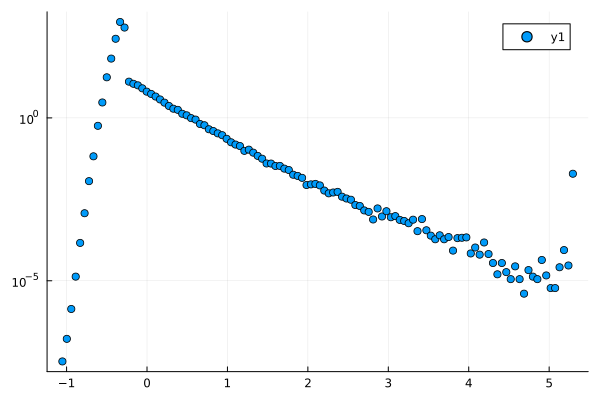

In [56]:
bmin = floor(minimum(flat_cross_corrs))
bmax = ceil(maximum(flat_cross_corrs))
Δb = 0.01
fh = FHist.Hist1D(flat_cross_corrs, binedges=bmin:Δb:bmax)

# Renormalize the histogram and shift the centers
μ, σ = mean(fh), std(fh)
centers = bincenters(fh)
centers .-= μ
centers ./= sqrt(2 * σ^2)
norm_counts = bincounts(fh) ./ (integral(fh) * Δb)
yy = [10^log(norm_counts[norm_counts.>0.0][i]) for i in eachindex(norm_counts[norm_counts.>0.0])]
centers = centers[norm_counts.>0.0]

scatter(centers, yy, yscale=:log10)

In [22]:
# savefig("./Images/long_MAD.png")